In [1]:
import pandas as pd
import numpy as np

from dataset.US_STATE_ABBREV import *

import folium 
import matplotlib.pyplot as plt
import seaborn as sn
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# 1. Data processing
## (a). Bubble Tea Location

In [2]:
bubble_tea = pd.read_csv('dataset/bubble_location_data.csv')
bubble_tea.head()

id                                     alias  \
0  wusuW7VDDWEGKfOBbm2k_g                     xing-fu-tang-flushing   
1  nndSS7va9wFlBYzA3zv1nw                  ojbk-tea-shop-brooklyn-2   
2  1gXKzs-1EPxJ7gkHW6SDyg  chun-yang-tea-flushing-new-york-flushing   
3  DbhBca8LzskjS0B-L4QfZg                      tiger-sugar-new-york   
4  Cml6xpr5GNhC_xI6iinHFw                  dragon-horn-tea-new-york   

                                name  \
0                       Xing Fu Tang   
1                      OJBK Tea Shop   
2  Chun Yang Tea - Flushing New York   
3                        Tiger Sugar   
4                    Dragon Horn Tea   

                                                 url  review_count  \
0  https://www.yelp.com/biz/xing-fu-tang-flushing...           186   
1  https://www.yelp.com/biz/ojbk-tea-shop-brookly...             8   
2  https://www.yelp.com/biz/chun-yang-tea-flushin...           119   
3  https://www.yelp.com/biz/tiger-sugar-new-york?...           346   
4  https://www.yelp.com/biz/dragon-horn-tea-new-y...            39   

                         categories  rating     transactions price  \
0     Bubble Tea/Desserts/Taiwanese     4.0  delivery/pickup     $   
1                        Bubble Tea     4.5  delivery/pickup     $   
2                        Bubble Tea     4.5  delivery/pickup   NaN   
3  Bubble Tea/Coffee & Tea/Desserts     4.0  delivery/pickup     $   
4           Bubble Tea/Coffee & Tea     4.5  delivery/pickup   NaN   

          phone   latitude  longitude                      display_address  \
0  1.646206e+10  40.758160 -73.829820     40-52 Main St Flushing, NY 11345   
1  1.718576e+10  40.693950 -73.963690    525 Myrtle Ave Brooklyn, NY 11205   
2  1.347733e+10  40.758001 -73.829948   133-41 41st Ave Flushing, NY 11355   
3  1.646591e+10  40.717151 -73.998231      197 Canal St New York, NY 10013   
4  1.646479e+10  40.708530 -74.013628  106 Greenwich St New York, NY 10006   

           address1 address2 address3      city  zip_code state country  
0     40-52 Main St      NaN      NaN  Flushing   11345.0    NY      US  
1    525 Myrtle Ave      NaN      NaN  Brooklyn   11205.0    NY      US  
2   133-41 41st Ave      NaN      NaN  Flushing   11355.0    NY      US  
3      197 Canal St      NaN      NaN  New York   10013.0    NY      US  
4  106 Greenwich St      NaN      NaN  New York   10006.0    NY      US

### Count the number of bubble tea shops for each state

In [3]:
bubble_tea_count = pd.DataFrame(bubble_tea.groupby('state').count().name)
bubble_tea_count.index.name = 'STNAME'
bubble_tea_count.columns = ['COUNT']
bubble_tea_count.head()

COUNT
STNAME       
AL         12
AR          7
AZ        111
CA       1818
CO         79

# 1.Data processing
## (b). Census Data : Age group for each county

In [4]:
agesex = pd.read_csv('dataset/cc-est2019-agesex.csv')
agesex.head()

SUMLEV  STATE  COUNTY   STNAME         CTYNAME  YEAR  POPESTIMATE  \
0      50      1       1  Alabama  Autauga County     1        54571   
1      50      1       1  Alabama  Autauga County     2        54597   
2      50      1       1  Alabama  Autauga County     3        54773   
3      50      1       1  Alabama  Autauga County     4        55227   
4      50      1       1  Alabama  Autauga County     5        54954   

   POPEST_MALE  POPEST_FEM  UNDER5_TOT  ...  AGE7579_FEM  AGE8084_TOT  \
0        26569       28002        3579  ...          705          731   
1        26584       28013        3584  ...          704          730   
2        26672       28101        3575  ...          707          743   
3        26981       28246        3551  ...          727          782   
4        26826       28128        3402  ...          751          834   

   AGE8084_MALE  AGE8084_FEM  AGE85PLUS_TOT  AGE85PLUS_MALE  AGE85PLUS_FEM  \
0           295          436            551             159            392   
1           294          436            551             159            392   
2           299          444            556             164            392   
3           315          467            601             191            410   
4           340          494            632             206            426   

   MEDIAN_AGE_TOT  MEDIAN_AGE_MALE  MEDIAN_AGE_FEM  
0            37.0             35.9            37.9  
1            37.0             35.9            37.8  
2            37.1             36.0            37.9  
3            37.3             36.2            38.4  
4            37.7             36.4            38.8  

[5 rows x 96 columns]

In [5]:
# create age group 14-24
agesex['AGE1424_TOT'] = agesex.AGE1417_TOT + agesex.AGE1824_TOT

# only keep 2019 data
agesex = agesex[agesex.YEAR==12]
agesex.reset_index(drop=True, inplace=True)

# select relevent features
agesex_colname = ["STNAME", "POPESTIMATE",
                 "AGE1424_TOT", "AGE2544_TOT", 
                  "AGE4564_TOT", "AGE65PLUS_TOT"]

agesex = agesex[agesex_colname]
agesex = agesex.groupby('STNAME').sum().reset_index()
agesex.STNAME = agesex.STNAME.map(lambda x : us_state_abbrev[x])

agesex.set_index('STNAME', inplace=True)

# convert the population to ratio
for name in agesex.columns:
    if agesex[name].dtype == int and name != 'POPESTIMATE':
        agesex[name] = agesex[name]/agesex["POPESTIMATE"]
        
agesex.drop(columns='POPESTIMATE', inplace=True)

In [6]:
agesex.head()

AGE1424_TOT  AGE2544_TOT  AGE4564_TOT  AGE65PLUS_TOT
STNAME                                                      
AL         0.142241     0.253006     0.259889       0.173323
AK         0.144996     0.291647     0.243962       0.125198
AZ         0.146815     0.261464     0.238075       0.179789
AR         0.144972     0.254202     0.247722       0.173597
CA         0.143920     0.286875     0.247174       0.147755

# 1.Data processing
## (c). Census Data : Total Population and East Asian population

In [7]:
east_asian = pd.read_csv('dataset/EAST_ASIAN_POP.csv')
east_asian = east_asian.groupby('STNAME').sum().reset_index()
east_asian.STNAME = east_asian.STNAME.map(lambda x : us_state_abbrev[x])
east_asian.set_index('STNAME', inplace=True)

In [8]:
east_asian.head()

TOT_POP  EAST_ASIAN_POP
STNAME                          
AL       4830620           10866
AK        733375           10479
AZ       6641928           33381
AR       2958208           10735
CA      38421464          664314

# 1.Data processing
## (d). Merge the three datasets

In [10]:
df = bubble_tea_count.copy()
df[agesex.columns] = agesex[agesex.columns]
df[east_asian.columns] = east_asian[east_asian.columns]
df.reset_index(inplace=True)

The population distribution is left skewed. Let's transform it with log function to make a normal distribution

In [11]:
logdf = df.copy()

for name in logdf.columns:
    if logdf[name].dtype==int or logdf[name].dtype==float:
        logdf[name] = np.log10(logdf[name])



<Figure size 288x432 with 0 Axes>

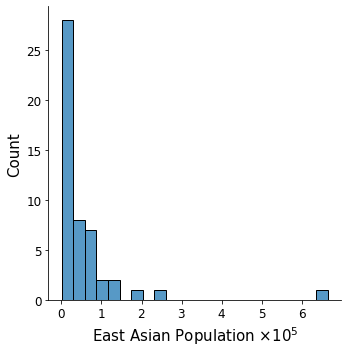

In [12]:
plt.figure(figsize=(4,6));
ax1 = sn.displot(data=df, x='EAST_ASIAN_POP');

ax1.ax.set_xticks([i*10**5 for i in range(7)]);
ax1.ax.set_xticklabels([r'$%d$'%i for i in range(7)]);
ax1.ax.set_xlabel(r'East Asian Population $ \times 10^5$');

<Figure size 288x432 with 0 Axes>

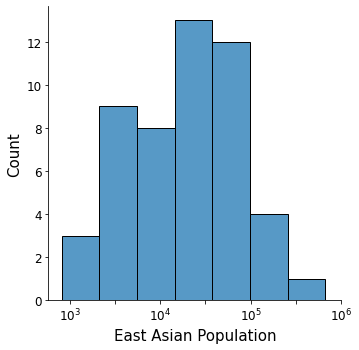

In [13]:
plt.figure(figsize=(4,6));
ax2 = sn.displot(data=logdf, x='EAST_ASIAN_POP');
ax2.ax.set_xticks([i for i in np.linspace(3, 6, 7)]);
ax2.ax.set_xticklabels([r'$10^{%d}$'%i if i.is_integer() else ' ' for i in np.linspace(3, 6, 7)]);
ax2.ax.set_xlabel('East Asian Population');

# 2. Exploratory Data Analysis
## (a). Visualize on map

In [14]:
usa_map = folium.Map([39.358, -98.118], zoom_start=4, tiles="Stamen toner")
for lat, lon, cat in zip(bubble_tea.latitude, bubble_tea.longitude, bubble_tea.name):
    folium.CircleMarker([lat, lon],radius=3, color=None,
                        fill_color='red',fill_opacity=0.3,
                        tooltip=cat).add_to(usa_map)
usa_map

# 2. Exploratory Data Analysis
## (b).  Number of bubble tea shop & Total population

Text(0, 0.5, 'State')

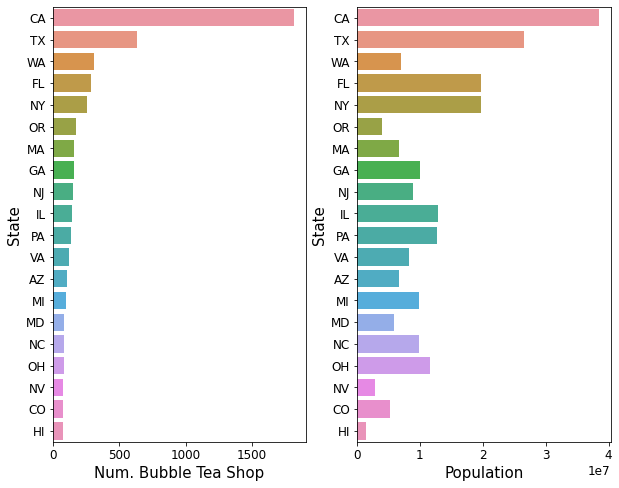

In [15]:
plt.figure(figsize=(10,8))
ax1= plt.subplot(121)
ax2= plt.subplot(122)

order = df.sort_values('COUNT',ascending=False)['STNAME']

sn.barplot(data=df, x='COUNT', y='STNAME', order=order[0:20], ax=ax1)
ax1.set_xlabel('Num. Bubble Tea Shop')
ax1.set_ylabel('State')


sn.barplot(data=df, x='TOT_POP', y='STNAME', order=order[0:20], ax=ax2)
ax2.set_xlabel('Population')
ax2.set_ylabel('State')



# 2. Exploratory Data Analysis
## (c). Number of bubble tea shop & East-Asian population

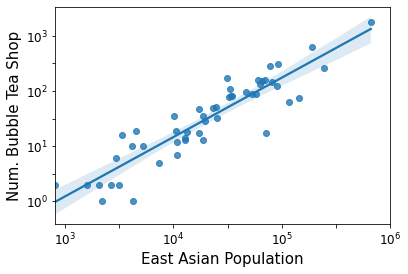

In [16]:
ax=sn.regplot(data=logdf, x='EAST_ASIAN_POP', y='COUNT')

ax.set_xlabel('East Asian Population')
ax.set_ylabel('Num. Bubble Tea Shop')


ax.set_xticks([i for i in np.linspace(3, 6, 7)]);
ax.set_yticks([i for i in np.linspace(0, 3, 7)]);

ax.set_xticklabels([r'$10^{%d}$'%i if i.is_integer() else ' ' for i in np.linspace(3, 6, 7)]);
ax.set_yticklabels([r'$10^{%d}$'%i if i.is_integer() else ' ' for i in np.linspace(0, 3, 7)]);

# 2. Exploratory Data Analysis
## (d). Age Group

In [17]:
df['logcount'] = df.COUNT.apply(np.log10)

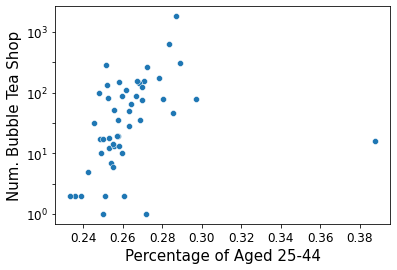

In [18]:
ax = sn.scatterplot(data=df, x='AGE2544_TOT', y='logcount')
ax.set_xlabel('Percentage of Aged 25-44')
ax.set_ylabel('Num. Bubble Tea Shop')
ax.set_yticks([i for i in np.linspace(0, 3, 7)]);
ax.set_yticklabels([r'$10^{%d}$'%i if i.is_integer() else ' ' for i in np.linspace(0, 3, 7)]);

Washington DC has anomalously many people in Age group 25-44.

(0.5, 3.5)

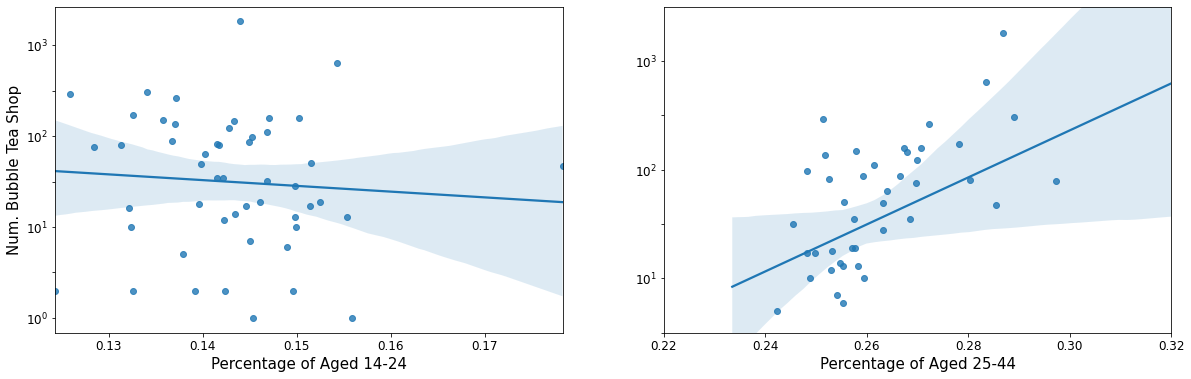

In [19]:
plt.figure(figsize=(20,6))
ax1= plt.subplot(121)
ax2= plt.subplot(122)

sn.regplot(data=df, x='AGE1424_TOT', y='logcount', ax=ax1)

ax1.set_xlabel('Percentage of Aged 14-24')
ax1.set_ylabel('Num. Bubble Tea Shop')
ax1.set_yticks([i for i in np.linspace(0, 3, 7)]);
ax1.set_yticklabels([r'$10^{%d}$'%i if i.is_integer() else ' ' for i in np.linspace(0, 3, 7)]);

sn.regplot(data=df, x='AGE2544_TOT', y='logcount', ax=ax2, robust=True)

ax2.set_xlabel('Percentage of Aged 25-44')
ax2.set_ylabel(' ')
ax2.set_yticks([i for i in np.linspace(0, 3, 7)]);
ax2.set_yticklabels([r'$10^{%d}$'%i if i.is_integer() else ' ' for i in np.linspace(0, 3, 7)]);
plt.xlim([0.22, 0.32])
plt.ylim([0.5, 3.5])

In [20]:
df.drop(columns=['logcount'], inplace=True)

<AxesSubplot:>

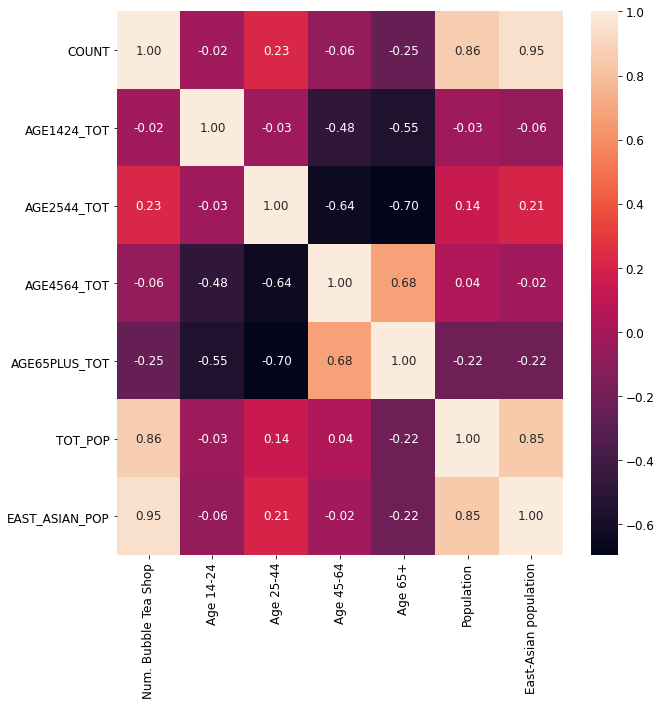

In [21]:
df_plot_corr = df.corr()
df_plot_corr.columns = ['Num. Bubble Tea Shop', 'Age 14-24', 'Age 25-44', 
                           'Age 45-64', 'Age 65+', 'Population', 'East-Asian population']

plt.figure(figsize=(10,10))
sn.heatmap(data = df_plot_corr, annot=True, fmt='.2f')



# 3. Modeling

# (a). Split training and test dataset

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = logdf.copy()

y = X.pop('COUNT')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=1)

X_train = X_train.drop(columns=['STNAME'])
test_label = X_test.pop('STNAME').values

y_test = y_test.values

# 3. Modeling
# (b). Grid Search Hyperparameter Tuning

In [24]:
#################################################
## Grid Search Hyperparameter Tuning
## I try two different regression models : svr and randomforest
## It turns out that the SVR performs better

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

GS_svr = GridSearchCV(SVR(), param_grid=param_grid, scoring='r2')
GS_svr = GS_svr.fit(X_train, y_train)

print("best svr parameters : ", GS_svr.best_params_)
print("best svr score : ", GS_svr.best_score_)

param_grid = [{'n_estimators':[i for i in range(50, 450, 50)]}]
GS_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, scoring='r2')
GS_rf = GS_rf.fit(X_train, y_train)

print("best Random Forest parameters : ", GS_rf.best_params_)
print("best rf score : ", GS_rf.best_score_)

best svr parameters :  {'C': 100, 'kernel': 'linear'}
best svr score :  -0.9588488390880763
best Random Forest parameters :  {'n_estimators': 150}
best rf score :  -2.3451984179857694


In [25]:
# best model
model = GS_svr.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

result = pd.DataFrame(np.array([y_pred, y_test]).T)
result.columns = ['y_predict', 'y_test']

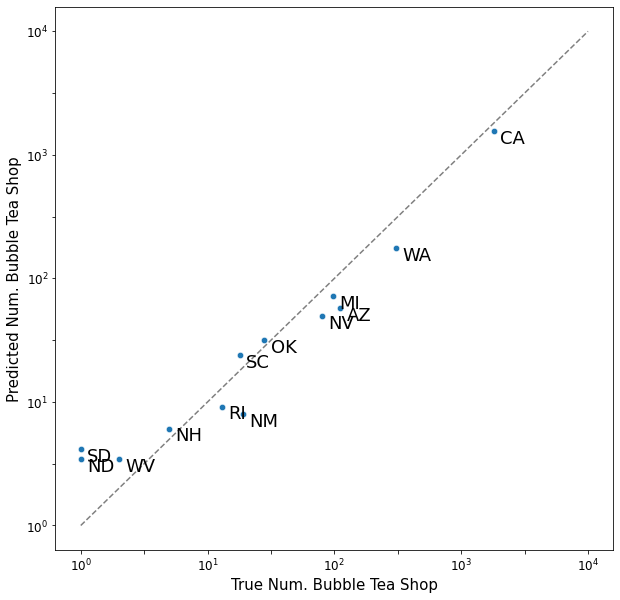

In [26]:
plt.figure(figsize=(10, 10))
plt.plot(np.linspace(0,4,101),np.linspace(0,4,101), 'k--', alpha=0.5)
ax = sn.scatterplot(data=result, x='y_test', y='y_predict',s=40 )

for x,y,lab in zip(result.y_test, result.y_predict, test_label):
    ax.text(x+0.05, y-0.1, lab, horizontalalignment='left', size=18, color='black')

labels = [r'$10^{%d}$'%e for i, e in enumerate(np.linspace(0, 4, 9))]
for i in range(len(labels)):
    if i%2==1:
        labels[i] = ''
        
ax.set_xlabel('True Num. Bubble Tea Shop')
ax.set_xticks([i for i in np.linspace(0, 4, 9)]);
ax.set_xticklabels(labels);

ax.set_ylabel('Predicted Num. Bubble Tea Shop')
ax.set_yticks([i for i in np.linspace(0, 4, 9)]);
ax.set_yticklabels(labels);

# 3. Modeliing

# (c) Permutation importance

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=list(X_test.columns))


/Users/zpcian/Library/Python/3.7/lib/python/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/zpcian/Library/Python/3.7/lib/python/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
